In [1]:
#| eval: true
#| echo: false
from IPython.display import Markdown, display

教師あり学習の例として回帰問題を取り上げます。回帰問題とは、入力変数から連続値の出力変数を予測する問題です。例えば、住宅の広さや築年数などの情報から住宅の価格を予測する問題は回帰問題として扱われます。

ここでは、回帰問題の代表的なモデルである線形回帰モデルについて説明します。線形回帰モデルは、入力変数と目的変数の間の線形関係をモデル化する統計的手法です。

線形回帰モデルなどの機械学習モデルの構築に必要なライブラリはScikit-learnに含まれています。ここではScikit-learnのいくつかの機能を利用して、ペンギンの体重を予測する線形回帰モデルを構築します。

利用するライブラリとデータを次のコードで読み込みます。


In [2]:
#| echo: fenced
# japanize_matplotlibのインストール
!pip install -qq japanize_matplotlib

In [3]:
import japanize_matplotlib  # matplotlibの日本語化
import matplotlib.pyplot as plt  # 作図
import numpy as np  # 数値計算、配列の操作
import pandas as pd  # データフレームの操作

In [4]:
# 以下は機械学習モデル（線形回帰モデル）の構築と性能評価に用いるモジュール
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ペンギンデータはseabornライブラリに含まれます。データを利用するには、まずはこのライブラリを読み込みます。


In [5]:
#| label: load-penguins
import seaborn as sns
# ペンギンデータの読み込み
penguins = sns.load_dataset("penguins")

先頭行を表示します。


In [6]:
# データの確認
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [7]:
# 列（変数）ごとの欠損値の数
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

## 前処理・特徴量エンジニアリング

一般的に欠損値を含むデータは、機械学習モデルに直接利用できません。そのため、欠損値の削除や欠損値の補完を行う必要があります。単純に欠損値を削除する方法がもっとも簡単な対策ですが、欠損値を削除すると、データの一部を失うことになるため、欠損値を含む行が多い場合やデータが少ない場合は注意が必要です。

### 欠損値の削除

ここでは欠損値の削除で、モデルに与えるデータを用意します。欠損値の削除は、pandasの`dropna()`メソッドを用いて行います。


In [8]:
# 前処理: 欠損値の削除
penguins.dropna(inplace=True)
# データの確認。欠損値の削除によっていくつかの行が削除される
penguins.shape

(333, 7)

### ラベルエンコーディングと標準化

次にペンギンデータの変数に対する操作、特徴量エンジニアリングを行います。ここではラベルエンコーディングと標準化を行うことにしましょう。どちらの操作も、特徴量エンジニアリングの工程では変数の変換に分類されます。

ラベルエンコーディングは、カテゴリ変数を数値に変換する操作です。[ロジスティック回帰モデル](../week04/0402_classification.qmd)を扱った際にも適用しました。


In [9]:
# 特徴量エンジニアリング: ラベルエンコーディングとスケーリング
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
penguins["species"] = le.fit_transform(penguins["species"])
penguins["island"] = le.fit_transform(penguins["island"])
penguins["sex"] = le.fit_transform(penguins["sex"])

標準化（スケーリング）は、変数の値を平均値0、標準偏差1に変換する操作です。標準化を行うことで、変数間のスケール（単位）を揃えることができます。例えば、ペンギンデータの体の部位は`mm`で記録されますが、くちばしの長さ`bill_length_mm`はくちばしの太さ`bill_depth_mm`よりも大きい値を取ります。また、体重は`g`で記録されます。このように単位が異なる変数をそのまま利用すると、値が大きな変数の影響が大きくなってしまいます。このような問題を解決するために、標準化を行います。


In [10]:
# ペンギンデータのbill_length_mmについて平均値と標準偏差を求める
print(penguins["bill_length_mm"].mean())
print(penguins["bill_length_mm"].std())

43.99279279279279
5.468668342647559


In [11]:
# bill_depth_mmについても平均値と標準偏差を求める
print(penguins["bill_depth_mm"].mean())
print(penguins["bill_depth_mm"].std())

17.164864864864864
1.9692354633199007


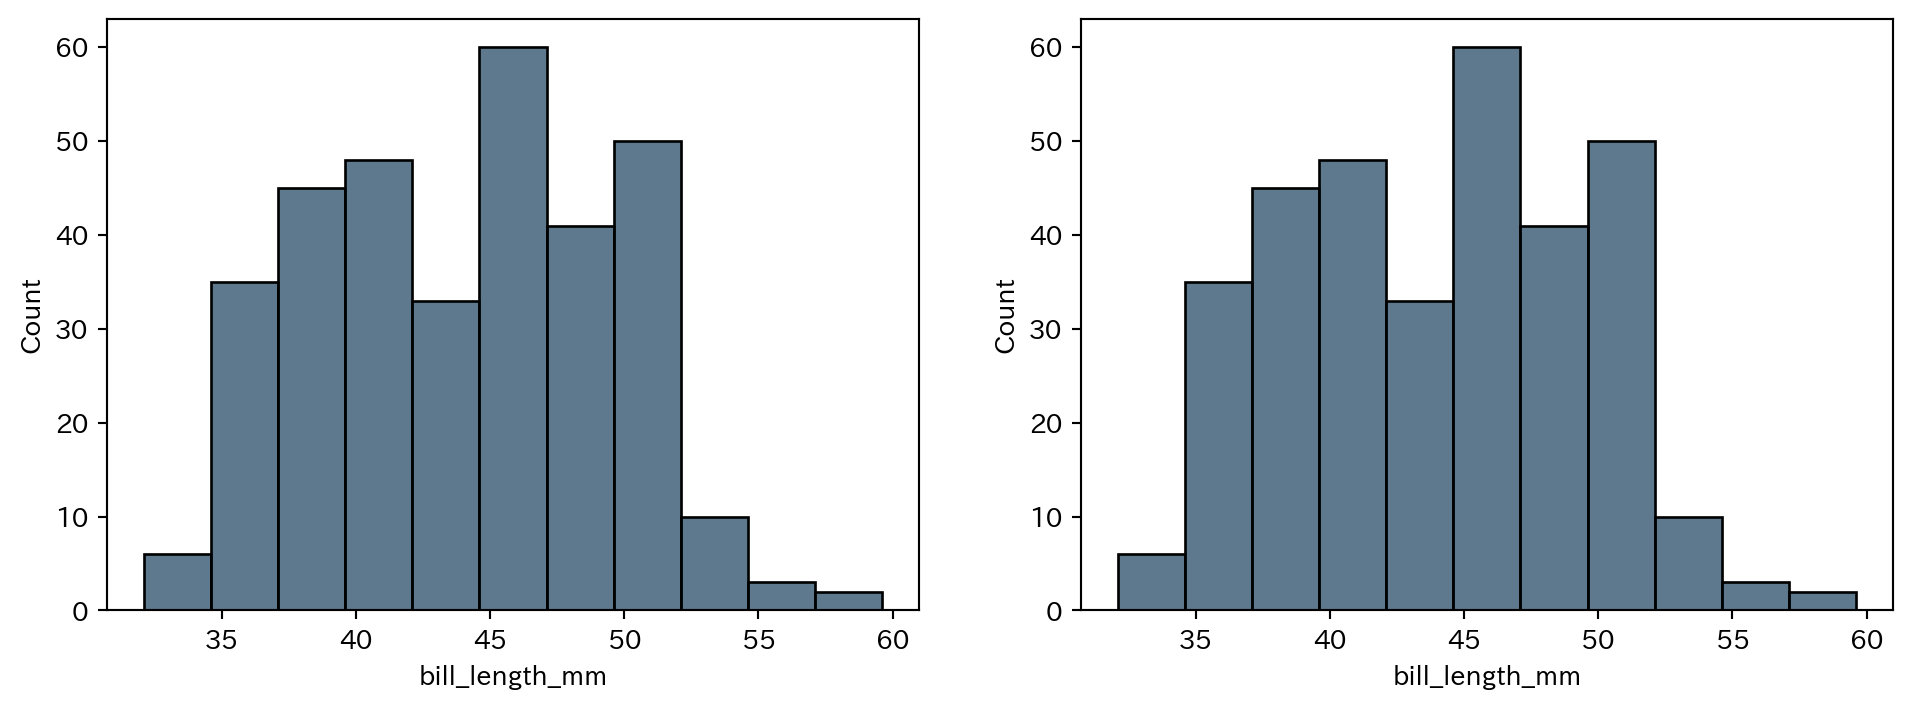

In [12]:
#| label: ペンギンデータのbill_length_mmとbill_depth_mmのヒストグラム
# ペンギンデータのbill_length_mmとbill_depth_mmのヒストグラムを作成
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(penguins, x="bill_length_mm", ax=ax[0], color="#284b67")
sns.histplot(penguins, x="bill_length_mm", ax=ax[1], color="#284b67")
plt.show()

scikit-learnでの標準化は、`StandardScaler`クラスを利用します。`StandardScaler`は、平均値と標準偏差を計算し、それらの値を利用して変数の値を変換します。標準化を行うことで、変数の値が平均値を中心に分布するようになります。


In [13]:
# データの標準化
# StandardScalerのインスタンスを用意
scaler = StandardScaler()
# ペンギンデータのbody_mass_g以外の数値変数をfit_transformメソッドにより標準化
penguins[
    ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
] = scaler.fit_transform(
    penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]]
)

ラベルエンコーディング、標準化を適用したデータを確認しましょう。


In [14]:
penguins.head(n=3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.896042,0.780732,-1.426752,3750.0,1
1,0,2,-0.822788,0.119584,-1.069474,3800.0,0
2,0,2,-0.676280,0.424729,-0.426373,3250.0,0


平均値0、標準偏差1に変換されていることが確認できます。


In [15]:
# ペンギンデータのbill_length_mmについて平均値と標準偏差を求める
print(penguins["bill_length_mm"].mean())
print(penguins["bill_length_mm"].std())

3.8407715446491904e-16
1.0015048917468008


In [16]:
# bill_depth_mmについても平均値と標準偏差を求める
print(penguins["bill_depth_mm"].mean())
print(penguins["bill_depth_mm"].std())

6.40128590774865e-16
1.0015048917468008


標準化は変数の値を操作しますが、変数の分布は変化しません。そのため、標準化を行う前後でヒストグラムを比較すると、分布の形に違いがないことがわかります。


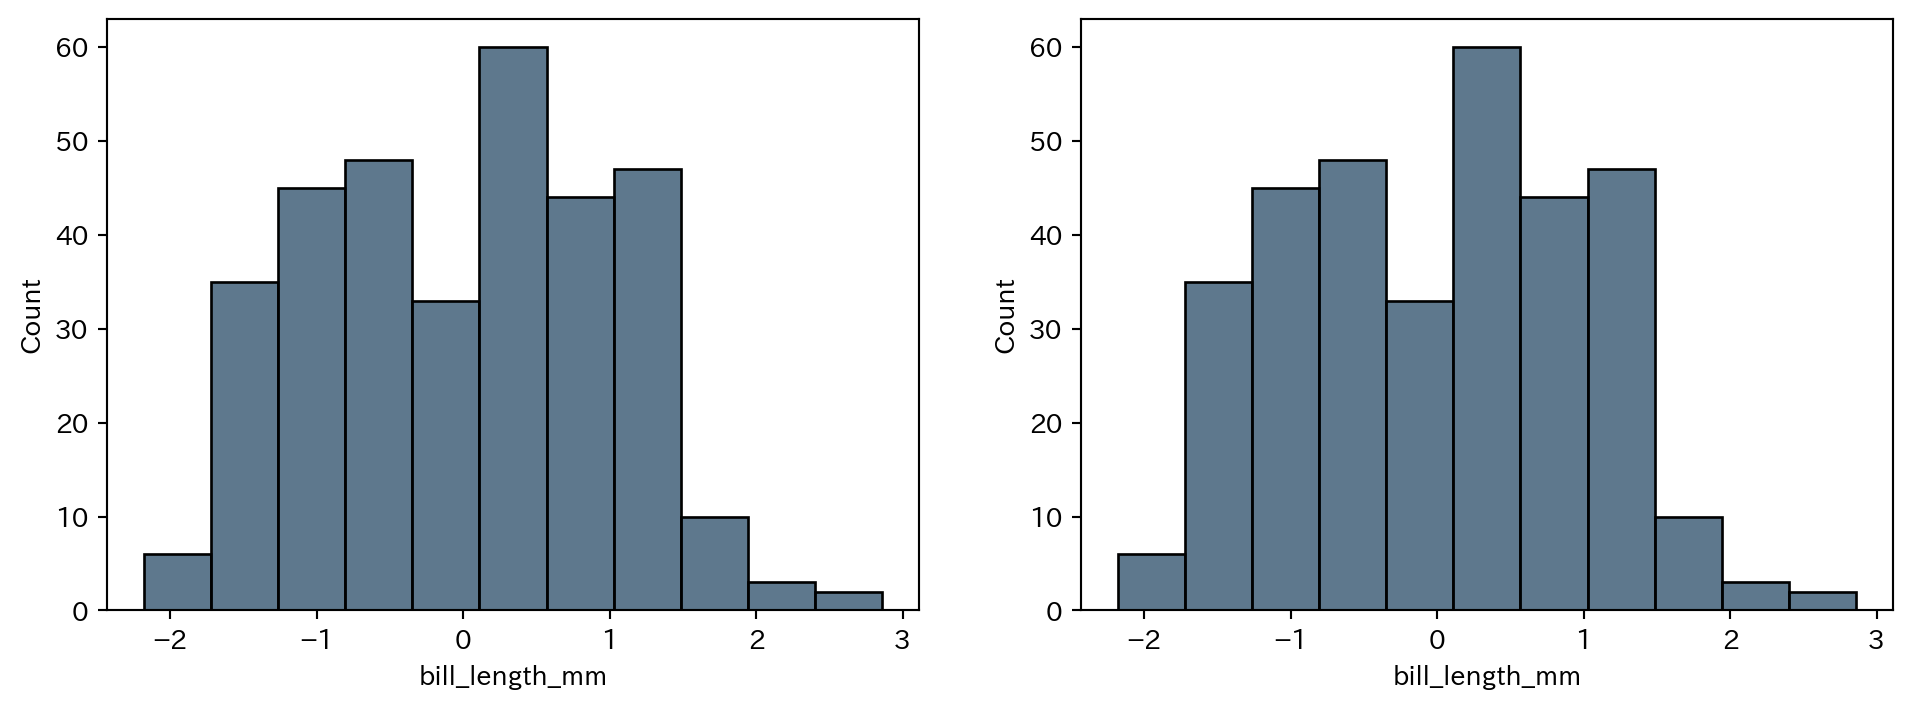

In [17]:
#| label: ペンギンデータのbill_length_mmとbill_depth_mmを標準化したヒストグラム
#| echo: false
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(penguins, x="bill_length_mm", ax=ax[0], color="#284b67")
sns.histplot(penguins, x="bill_length_mm", ax=ax[1], color="#284b67")
plt.show()

ここでは特徴量エンジニアリングの例として、ラベルエンコーディングと標準化を紹介しました。いずれも元の変数の値を別の値に置き換える操作となります。一方、特徴量エンジニアリングには既存のデータには存在しない、新しい変数を作成する工程も含まれます。例えば、身長と体重の変数を利用し、BMIを計算するなどがあります。またダミー変数化も既存の変数の情報をもとに変数を作成します。

## 関数化による工程の整理

ここまでのデータの前処理・特徴量エンジニアリングの操作を整理してみましょう。具体的には一連のコードを関数として定義します。関数を作成することで、同じ処理を何度も繰り返す必要がなくなる利点があります。また、処理の流れの整理にも役立ちます。

関数の定義は、以下のように`def`構文を利用します。`def`のあとに関数名を指定します。関数名は、任意の名前を付けることができますが、関数の処理内容がわかりやすい名前を付けるようにしましょう。ここではペンギンデータの前処理までを実行する関数として`penguins_preprocess()`という名前を付けます。


In [18]:
# 関数定義の例
def penguins_preprocess(data):
    # 処理内容の記述
    return data

関数名の後には、括弧の中で引数を指定します。引数は、関数の実行に必要な情報を渡すためのものです。ここでは入力データを指定するために`data`という引数を指定しています。関数の処理内容は、コロンのあとにインデントを利用して記述します。関数の処理が終わったら、`return`構文を利用して関数が返却する値（戻り値）を指定します。

具体的なペンギンデータへの前処理・特徴量エンジニアリングの操作を関数化したものが以下になります。


In [19]:
def penguins_preprocess(data):
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    
    # 元のデータを保持するためデータをコピー
    data_processed = data.copy()

    # 前処理: 欠損値の削除
    data_processed.dropna(inplace=True)

    # 特徴量エンジニアリング: ラベルエンコーディング
    le = LabelEncoder()
    for col in ["species", "island", "sex"]:
        data_processed[col] = le.fit_transform(data_processed[col])

    # 特徴量エンジニアリング: データの標準化
    scaler = StandardScaler()
    data_processed[
        ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
    ] = scaler.fit_transform(
        data_processed[["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]]
    )

    return data_processed

定義した関数は`penguins_preprocess()`として機能します。もう一度、ペンギンデータを読み込み、`penguins_preprocess()`関数による前処理・特徴量エンジニアリングを実行してみましょう。


In [20]:
# ペンギンデータの読み込み
penguins = sns.load_dataset("penguins")

# 前処理と特徴量エンジニアリングの実行
penguins_baked = penguins_preprocess(penguins)

結果を確認します。関数で定義したラベルエンコーディング、標準化の処理が実行されていることがわかります。関数を利用することで複数の処理を一度に実行できるようになりました。


In [21]:
penguins_baked.head(n=3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.896042,0.780732,-1.426752,3750.0,1
1,0,2,-0.822788,0.119584,-1.069474,3800.0,0
2,0,2,-0.676280,0.424729,-0.426373,3250.0,0


## データの分割

モデルの学習の前に、予測の対象となる変数（目的変数）とそれ以外の変数（説明変数）に分割します。今回、目的変数は`body_mass_g`、説明変数は`body_mass_g`以外の変数となります。


In [22]:
# 説明変数と目的変数の設定
# Xとしてbody_mass_g以外の変数を、yとしてbody_mass_gを設定
X = penguins_baked.drop(columns="body_mass_g")
y = penguins_baked["body_mass_g"]

以上でデータの準備は完了です。次に、データをモデルの学習に用いる訓練データと、評価に利用するテストデータに分割します。今回は、訓練・テストデータに含まれる`species`の割合が均等となるように分割します。このようなグループ間の割合を一定にする分割方法を層化抽出と呼びます。

scikit-learnの`train_test_split()`関数を使用してデータ分割をします。引数により、テスト用データを20%（学習用データを80%）、`species`変数による層化抽出を行うように指定します。

![ホールドアウト法](../img/hold-out.png)


In [23]:
# データ分割
# test_size=0.2でテストデータの割合を20%に指定
# random_stateは乱数のシードを指定。これにより、実行するたびに同じデータ分割を行うことができる
# stratifyで層化抽出を行う。今回はspeciesを指定
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=20230515, stratify=X["species"]
)

In [24]:
penguins_baked.groupby("species").size()

species
0    146
1     68
2    119
dtype: int64

In [25]:
X_train.groupby("species").size()

species
0    117
1     54
2     95
dtype: int64

In [26]:
X_test.groupby("species").size()

species
0    29
1    14
2    24
dtype: int64

## モデルの学習と予測

Scikit-learnでの線形回帰モデルの構築は`sklearn.linear_model`モジュールの`LinearRegression`クラスで行います。


In [27]:
#| label: モデルの学習
# インスタンスの生成
lr = LinearRegression()
# fitメソッドでモデルの学習を実行
# 訓練データ（X_train, y_train）を引数に指定
lr.fit(X_train, y_train)

LinearRegression()

In [28]:
#| label: 予測
# predictメソッドで予測を実行
# 訓練データとテストデータをそれぞれを引数に指定し、予測値を得る
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# 予測値の確認
# body_mass_gは標準化を適用していないため、もとのg単位での予測値となる
y_pred_test

array([4783.75905524, 5257.63304031, 4622.73374997, 5440.80373253,
       3315.95001135, 3449.22324626, 4182.91106858, 3779.31387801,
       5332.35879539, 5615.37691183, 4585.19536602, 4544.85274993,
       3378.95494568, 4651.41753751, 3637.0685959 , 4669.99108179,
       3941.43440199, 4058.0413563 , 3856.80769412, 3367.99787016,
       4749.28198692, 5560.64069046, 4110.84101703, 4214.64059372,
       3900.7371804 , 4580.99680682, 3912.27828029, 4710.12053689,
       4220.79338127, 4133.35394733, 5469.58813153, 3886.77989401,
       5408.29101883, 4445.499841  , 4016.26966443, 3832.29357079,
       4726.61353707, 4085.79256734, 3591.65543457, 5495.44906674,
       3255.90273903, 5472.53021551, 4842.32420278, 3380.23258003,
       4197.5492215 , 4581.65490999, 4574.81831498, 3350.66554298,
       4808.00360649, 3971.2999061 , 3597.35269633, 3601.3340526 ,
       3132.39715024, 3644.53494959, 4144.78838762, 4184.99465485,
       3948.11374387, 3508.36355321, 3265.37178874, 3950.86206

predictメソッドにより、訓練データとテストデータそれぞれの予測値を得ることができました。次に、モデルの評価を行います。


In [29]:
#| eval: false
#| echo: false
coef = lr.coef_  # 回帰係数の取得
intercept = lr.intercept_  # 切片の取得

## 評価

回帰モデルの性能評価は実測値と予測値の間の誤差を用いた指標を利用します。主に使われる誤差の指標として次のものがあります。

- 平均絶対誤差（Mean Absolute Error: MAE）: 実際の値と予測値との絶対値の差を平均したもの。MAEが小さいほど誤差は小さく、予測精度が高いと言える。一方で外れ値の影響を受けやすい。
- 平均二乗誤差（Mean Squared Error: MSE）: 実際の値と予測値との差（予測誤差）を二乗して平均したもの。MSEが小さいほど誤差は小さく、予測精度が高いと言える。
- 二乗平均平方根誤差（Root Mean Squared Error: RMSE）: MSEの平方根を求めたもの。MSEと同様、値が小さいほど誤差は小さく、予測精度が高いと言える。誤差のスケールが目的変数と同じスケールになるため、解釈が直感的になる。
- 決定係数（R-squared, $R^2$）: モデルの当てはまりの良さを示す指標。1に近いほど予測精度が高いと言える。ただし、説明変数の数が増加し、モデルが複雑になると、$R^2$の値が大きくなりやすいという欠点がある。

モデルや問題設定により、参照すべき適切な評価指標は異なります。例えば、MAEやMSEは外れ値の影響を受けやすいため、外れ値が多いデータではRMSEや決定係数を評価指標に用いるのが適切です。

今回は、誤差の指標としてRMSEと決定係数を用います。RMSEは次の式で計算できます。

$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=0}^{n-1} (y_{i} - \hat{y}_{})^2}
$$

- $n$: データの件数
- $y_{i}$: $i$番目のデータの実測値
- $\hat{y}_{i}$: $i$番目のデータの予測値

つまり、各観測値について実際の値と予測値の差を二乗し、その平均を取った後、平方根を求めることでRMSEが計算できます。

決定係数0から1の値を取る指標です。1に近いほどモデルの予測が実測値に近い、つまりモデルの精度が高いことを示します。

決定係数は次の式で計算されます。

$$
R^2 = 1 - \frac{RSS}{TSS}
$$

ここで $RSS$ は残差平方和（Residual Sum of Squares）、$TSS$ は全平方和（Total Sum of Squares）と呼ばれるもので、それぞれ次の式で計算できます。

$$
RSS = \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^2
$$

$RSS$ は実際の値と予測値との差を2乗し、それらをすべて足し合わせたものです。これはモデルの予測値が実際の値からどの程度離れているかを示す指標となります。

一方、$TSS$ は予測値の代わりに実際の値の平均値 $\bar{y}$ を用います。モデルの予測値は関係なく、実際の値が全体の平均値からどの程度離れているかを示す指標となります。言い換えるとデータの全体的なバラつきを表すと考えることができます。

決定係数に話しを戻しましょう。決定係数は $1-\frac{RSS}{TSS}$ で求められます。残差平方和（予測のズレ）が全平方和（データ全体のバラつき）に対してどれだけ小さいかを示す指標となります。これによりモデルの予測が実際のデータにどれだけ当てはまるかを評価することができます。

これらの指標は、scikit-learnのsklearn.metricsモジュールに含まれる`mean_squared_error()`関数と`r2_score()`関数を用いて計算することができます。


In [30]:
#| label: モデルの評価
# RMSEを求める
# squared=Falseを指定することで、RMSEを計算することができる（デフォルトはMSE）
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, squared=False))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test, squared=False))

# 決定係数を求める
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

出力を表形式にして見やすくします。


In [31]:
pd.DataFrame(
    data={
        "データの種類": ["訓練データ", "テストデータ"],
        "RMSE": [train_rmse, test_rmse],
        "R2": [train_r2, test_r2],
    }
)

,データの種類,RMSE,R2
0,訓練データ,17.934423,0.846080
1,テストデータ,18.564218,0.780487


In [32]:
#| eval: true
#| echo: false
display(
    Markdown(
        """
訓練データ、テストデータのRMSEはそれぞれ {train_rmse}、{test_rmse}で、その差は{diff}です。2つのデータセットの間での差はわずかで、訓練データとテストデータの両方でモデルの精度が同等であることを示しています。
""".format(
            train_rmse=round(train_rmse, 3),
            test_rmse=round(test_rmse, 3),
            diff=round(abs(train_rmse - test_rmse), 3),
        )
    )
)


訓練データ、テストデータのRMSEはそれぞれ 17.934、18.564で、その差は0.63です。2つのデータセットの間での差はわずかで、訓練データとテストデータの両方でモデルの精度が同等であることを示しています。


RMSEが訓練データとテストデータの両方で値が大きくなっている場合、モデルが訓練データに対して過学習していることを示しています。逆に、訓練データでのRMSEがテストデータのRMSEよりも極端に大きい場合、それはモデルが未学習である可能性を示します。


In [33]:
#| eval: true
#| echo: false
display(
    Markdown(
        """
$R^2$についても見てみましょう。訓練データ、テストデータそれぞれの値は{train_r2}と{test_r2}となりました。これはモデルが訓練データの分散の約{train_r2}%を説明できているということを示します。同様にテストデータに対しても{test_r2}%を説明することになります。
""".format(
            train_r2=round(train_r2, 3),
            test_r2=round(test_r2, 3),
            diff=round(abs(train_r2 - test_r2), 3),
        )
    )
)


$R^2$についても見てみましょう。訓練データ、テストデータそれぞれの値は0.846と0.78となりました。これはモデルが訓練データの分散の約0.846%を説明できているということを示します。同様にテストデータに対しても0.78%を説明することになります。


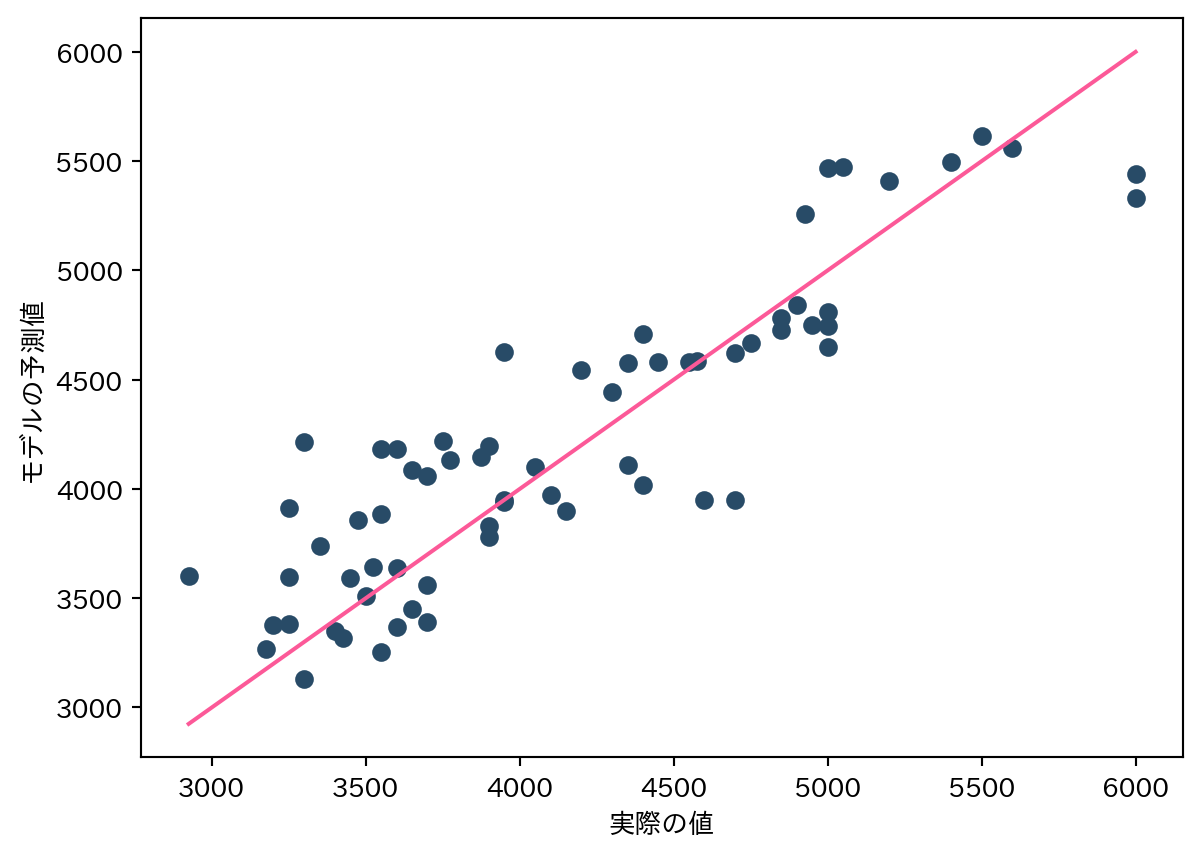

In [34]:
# 実測値と予測値をプロット
plt.scatter(y_test, y_pred_test, color="#284b67")
plt.xlabel("実際の値")
plt.ylabel("モデルの予測値")

# 実際の値と予測値が正確であれば、予測値は実測値と一致するため、
# 対角線上（左下から右上への線）に点がプロットされる
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="#fc5998")

plt.show()